# Connect4 Lookahead Hyperparameter Round Robin

This notebook runs a **round robin tournament** between multiple `Connect4Lookahead` variants created from a hyperparameter grid.

You can sweep (all at once):
- `DEFENSIVE`
- `FLOATING_NEAR`
- `FLOATING_FAR`
- `CENTER_BONUS`
- eval weights: `(2, W2)`, `(3, W3)`, `(4, W4)`

It reports:
- Pairwise points-per-game matrix (win=1, draw=0.5, loss=0)
- Metascore (avg points/game vs all others)
- Heatmap + metascore bar chart
- Optional CSV exports

> Tip: keep the grid small at first. Product grids explode faster than a poorly-placed connect-4 fork.


In [1]:
from tqdm.auto import tqdm
# --- imports / path ---
import os, sys, math, itertools, time
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If this notebook isn't run from repo root, adjust accordingly:
# sys.path.append("..")  # e.g. if notebook is in a subfolder

from C4.fast_connect4_lookahead import Connect4Lookahead, C4_WIN

# Opening noise distribution (prefer importing your canonical config)
try:
    from C4.eval_oppo_dict import OPENING_NOISE_K
except Exception:
    OPENING_NOISE_K = {0: 0.70, 1: 0.20, 2: 0.10}

OPENING_NOISE_K = dict(OPENING_NOISE_K)
assert abs(sum(OPENING_NOISE_K.values()) - 1.0) < 1e-6, OPENING_NOISE_K

print("Imported OPENING_NOISE_K =", OPENING_NOISE_K)
print("C4_WIN =", C4_WIN)


Imported OPENING_NOISE_K = {0: 0.7, 1: 0.2, 2: 0.1}
C4_WIN = 100000.0


In [2]:
# --- tournament / search settings (edit me) ---

# Fixed lookahead depth for *all* agents
DEPTH = 5

# Games per pair (each pair will play 2*GAMES_PER_PAIR games because we alternate starting player)
GAMES_PER_PAIR = 10

# Opening noise:
# We interpret OPENING_NOISE_K as a distribution over 'k', where:
#   k=0 -> pick best move
#   k=1 -> uniform among top-2 moves
#   k=2 -> uniform among top-3 moves
# Only applied for the first OPENING_PLY_LIMIT plies of the game.
OPENING_PLY_LIMIT = 2
OPENING_SCORE_DEPTH = min(DEPTH, 3)  # keep opening scoring cheaper than full depth

# Random seed for reproducibility
SEED = 12345

# --- hyperparameter grid ---
GRID = {
    "DEFENSIVE":      [1.0],
    "FLOATING_NEAR":  [0.75],
    "FLOATING_FAR":   [0.5, 0.01, 0.1],
    "CENTER_BONUS":   [10],

    # weights for (2,3,4) in C4_DEFAULT_WEIGHTS_ITEMS
    "W2": [1],
    "W3": [1000.0, ],
    "W4": [C4_WIN],  # usually keep this at C4_WIN; but you *can* try [0.5*C4_WIN, C4_WIN, 2*C4_WIN]
}


# Hard cap on number of variants to avoid accidental combinatorial disasters
MAX_VARIANTS = 128

print("Grid sizes:", {k: len(v) for k,v in GRID.items()})


Grid sizes: {'DEFENSIVE': 1, 'FLOATING_NEAR': 1, 'FLOATING_FAR': 3, 'CENTER_BONUS': 1, 'W2': 1, 'W3': 1, 'W4': 1}


In [3]:
# --- build agent variants ---

@dataclass(frozen=True)
class VariantCfg:
    DEFENSIVE: float
    FLOATING_NEAR: float
    FLOATING_FAR: float
    CENTER_BONUS: float
    W2: float
    W3: float
    W4: float

def iter_cfgs(grid: Dict[str, List[float]]) -> List[VariantCfg]:
    keys = ["DEFENSIVE", "FLOATING_NEAR", "FLOATING_FAR", "CENTER_BONUS", "W2", "W3", "W4"]
    vals = [grid[k] for k in keys]
    cfgs = []
    for tup in itertools.product(*vals):
        cfgs.append(VariantCfg(*map(float, tup)))
    return cfgs

cfgs = iter_cfgs(GRID)

if len(cfgs) > MAX_VARIANTS:
    print(f"WARNING: {len(cfgs)} variants in full grid, capping to MAX_VARIANTS={MAX_VARIANTS}.")
    cfgs = cfgs[:MAX_VARIANTS]

def make_agent(cfg: VariantCfg) -> Connect4Lookahead:
    a = Connect4Lookahead(weights={2: cfg.W2, 3: cfg.W3, 4: cfg.W4})
    a.DEFENSIVE = float(cfg.DEFENSIVE)
    a.FLOATING_NEAR = float(cfg.FLOATING_NEAR)
    a.FLOATING_FAR = float(cfg.FLOATING_FAR)
    a.CENTER_BONUS = float(cfg.CENTER_BONUS)
    a._variant_cfg = cfg  # attach for reporting
    return a

agents = [make_agent(c) for c in cfgs]

def short_name(cfg: VariantCfg, i: int) -> str:
    return (f"V{i:02d} D{cfg.DEFENSIVE:g} FN{cfg.FLOATING_NEAR:g} FF{cfg.FLOATING_FAR:g} "
            f"CB{cfg.CENTER_BONUS:g} W2{cfg.W2:g} W3{cfg.W3:g}")

names = [short_name(a._variant_cfg, i) for i, a in enumerate(agents)]
print("Variants:", len(agents))
print(names[0])


Variants: 3
V00 D1 FN0.75 FF0.5 CB10 W21 W31000


In [4]:
# --- game mechanics (simple, deterministic rules) ---

ROWS, COLS = 6, 7

def legal_moves(board: np.ndarray) -> List[int]:
    # top row occupancy decides legality
    return [c for c in range(COLS) if board[0, c] == 0]

def apply_move(board: np.ndarray, col: int, player: int) -> None:
    # drop into lowest empty row
    for r in range(ROWS - 1, -1, -1):
        if board[r, col] == 0:
            board[r, col] = player
            return
    raise ValueError(f"Column {col} is full")

def is_draw(board: np.ndarray) -> bool:
    return all(board[0, c] != 0 for c in range(COLS))

def winner(board: np.ndarray, agent: Connect4Lookahead) -> int:
    # 0 none, 1 player1, 2 player2
    if agent.has_four(board, 1):
        return 1
    if agent.has_four(board, 2):
        return 2
    return 0

# Opening noise: sample k according to OPENING_NOISE_K, then choose uniform among top-(k+1)
def choose_with_opening_noise(agent: Connect4Lookahead, board: np.ndarray, player: int, rng: np.random.Generator) -> int:
    # sample k
    ks = np.array(sorted(OPENING_NOISE_K.keys()), dtype=int)
    ps = np.array([OPENING_NOISE_K[k] for k in ks], dtype=float)
    k = int(rng.choice(ks, p=ps))

    if k <= 0:
        return int(agent.n_step_lookahead(board, player, depth=DEPTH))

    # compute action scores cheaply for opening only
    scores = agent.n_step_action_scores(board, player, depth=OPENING_SCORE_DEPTH)
    legal = legal_moves(board)
    if not legal:
        return 0

    # rank legal by score desc
    ranked = sorted(legal, key=lambda c: float(scores[c]), reverse=True)
    topn = ranked[: min(len(ranked), k + 1)]
    return int(rng.choice(topn))

def select_action(agent: Connect4Lookahead, board: np.ndarray, player: int, ply: int, rng: np.random.Generator) -> int:
    # apply noise only in the opening plies
    if ply < OPENING_PLY_LIMIT:
        return choose_with_opening_noise(agent, board, player, rng)
    return int(agent.n_step_lookahead(board, player, depth=DEPTH))

def play_game(a1: Connect4Lookahead, a2: Connect4Lookahead, start_player: int, rng: np.random.Generator) -> int:
    """Return winner: 0 draw, 1 if a1 wins, 2 if a2 wins."""
    board = np.zeros((ROWS, COLS), dtype=np.int8)

    # mapping: board uses players 1/2. If start_player==1 => a1 plays as 1, else a2 plays as 1.
    if start_player == 1:
        agent_for = {1: a1, 2: a2}
    else:
        agent_for = {1: a2, 2: a1}

    ply = 0
    while True:
        w = winner(board, a1)  # winner() only needs a has_four implementation; any instance works
        if w != 0:
            # translate back to "did a1 win?" etc.
            if start_player == 1:
                return 1 if w == 1 else 2
            else:
                return 2 if w == 1 else 1

        if is_draw(board):
            return 0

        p = 1 if (ply % 2 == 0) else 2
        agent = agent_for[p]
        col = select_action(agent, board, p, ply, rng)

        # ultra-defensive legality fallback
        lm = legal_moves(board)
        if col not in lm:
            col = int(rng.choice(lm))

        apply_move(board, col, p)
        ply += 1


In [5]:
from tqdm.auto import tqdm

# --- round robin ---

rng = np.random.default_rng(SEED)
N = len(agents)

# points matrix: row i vs col j = avg points for i against j
P = np.full((N, N), np.nan, dtype=np.float64)

# book-keeping
results = []  # list of dicts for a long-form df

t0 = time.time()
for i in range(N):
    P[i, i] = np.nan

pairs = [(i, j) for i in range(N) for j in range(i + 1, N)]

for (i, j) in tqdm(pairs, desc="Round robin pairs", unit="pair"):
    a, b = agents[i], agents[j]

    pts_i = 0.0
    pts_j = 0.0
    games = 0

    # alternate starting player by swapping who is 'player 1' in play_game
    for g in range(GAMES_PER_PAIR):
        # game 1: i starts
        w = play_game(a, b, start_player=1, rng=rng)
        games += 1
        if w == 1:
            pts_i += 1.0
        elif w == 2:
            pts_j += 1.0
        else:
            pts_i += 0.5
            pts_j += 0.5

        # game 2: j starts
        w = play_game(a, b, start_player=2, rng=rng)
        games += 1
        if w == 1:
            pts_i += 1.0
        elif w == 2:
            pts_j += 1.0
        else:
            pts_i += 0.5
            pts_j += 0.5

    P[i, j] = pts_i / games
    P[j, i] = pts_j / games

    results.append({
        "i": i, "j": j, "name_i": names[i], "name_j": names[j],
        "points_i": pts_i, "points_j": pts_j, "games": games,
        "ppg_i": P[i, j], "ppg_j": P[j, i],
    })

dt = time.time() - t0
print(f"Done: N={N}, games per pair={2*GAMES_PER_PAIR}, elapsed={dt:.1f}s")


Round robin pairs:   0%|          | 0/3 [00:00<?, ?pair/s]

Done: N=3, games per pair=20, elapsed=5.0s


In [6]:
# --- metascore report ---

df_pairs = pd.DataFrame(results)
display(df_pairs.head())

# metascore: average of row vs others (ignore diagonal)
metas = []
for i in range(N):
    row = [P[i, j] for j in range(N) if j != i]
    metas.append(float(np.mean(row)) if row else float('nan'))

df_meta = pd.DataFrame({
    "variant": [f"V{i:02d}" for i in range(N)],
    "name": names,
    "metascore": metas,
    "DEFENSIVE": [a._variant_cfg.DEFENSIVE for a in agents],
    "FLOATING_NEAR": [a._variant_cfg.FLOATING_NEAR for a in agents],
    "FLOATING_FAR": [a._variant_cfg.FLOATING_FAR for a in agents],
    "CENTER_BONUS": [a._variant_cfg.CENTER_BONUS for a in agents],
    "W2": [a._variant_cfg.W2 for a in agents],
    "W3": [a._variant_cfg.W3 for a in agents],
    "W4": [a._variant_cfg.W4 for a in agents],
}).sort_values("metascore", ascending=False).reset_index(drop=True)

display(df_meta.head(15))

best = df_meta.iloc[0]
print("\nBest variant:", best["variant"], "metascore=", best["metascore"])
print(best[["DEFENSIVE","FLOATING_NEAR","FLOATING_FAR","CENTER_BONUS","W2","W3","W4"]].to_dict())


,i,j,name_i,name_j,points_i,points_j,games,ppg_i,ppg_j
0,0,1,V00 D1 FN0.75 FF0.5 CB10 W21 W31000,V01 D1 FN0.75 FF0.01 CB10 W21 W31000,7.0,13.0,20,0.35,0.65
1,0,2,V00 D1 FN0.75 FF0.5 CB10 W21 W31000,V02 D1 FN0.75 FF0.1 CB10 W21 W31000,9.0,11.0,20,0.45,0.55
2,1,2,V01 D1 FN0.75 FF0.01 CB10 W21 W31000,V02 D1 FN0.75 FF0.1 CB10 W21 W31000,11.0,9.0,20,0.55,0.45


,variant,name,metascore,DEFENSIVE,FLOATING_NEAR,FLOATING_FAR,CENTER_BONUS,W2,W3,W4
0,V01,V01 D1 FN0.75 FF0.01 CB10 W21 W31000,0.6,1.0,0.75,0.01,10.0,1.0,1000.0,100000.0
1,V02,V02 D1 FN0.75 FF0.1 CB10 W21 W31000,0.5,1.0,0.75,0.10,10.0,1.0,1000.0,100000.0
2,V00,V00 D1 FN0.75 FF0.5 CB10 W21 W31000,0.4,1.0,0.75,0.50,10.0,1.0,1000.0,100000.0



Best variant: V01 metascore= 0.6000000000000001
{'DEFENSIVE': 1.0, 'FLOATING_NEAR': 0.75, 'FLOATING_FAR': 0.01, 'CENTER_BONUS': 10.0, 'W2': 1.0, 'W3': 1000.0, 'W4': 100000.0}


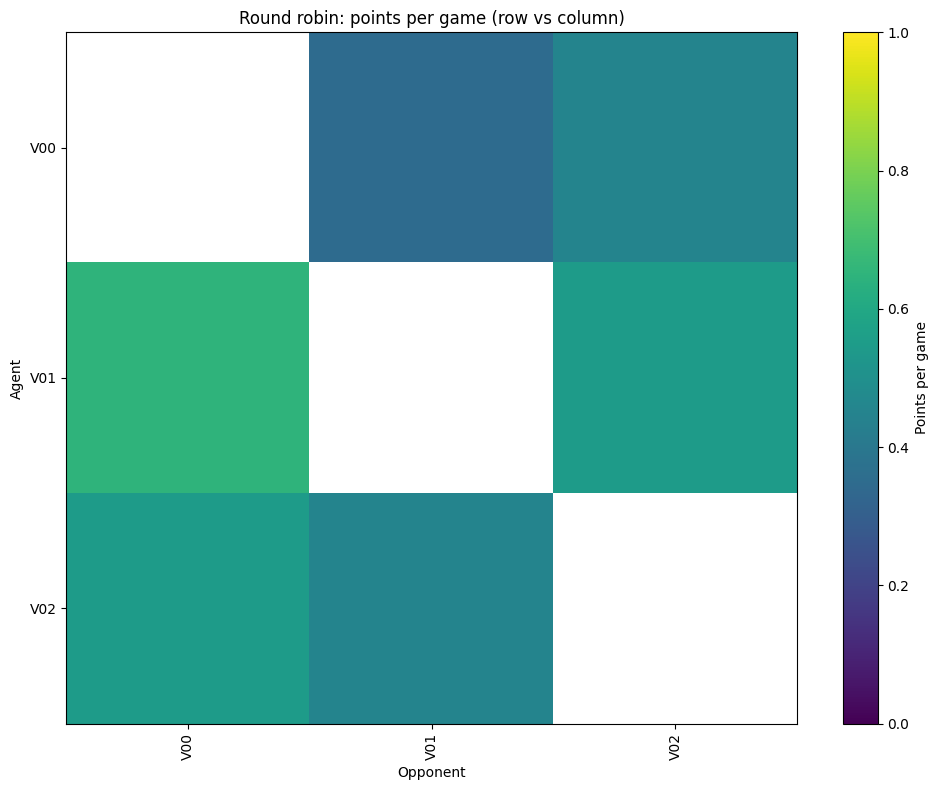

In [7]:
# --- heatmap (points per game) ---

fig = plt.figure(figsize=(10, 8))
ax = plt.gca()
im = ax.imshow(P, aspect="auto", vmin=0.0, vmax=1.0)

ax.set_title("Round robin: points per game (row vs column)")
ax.set_xlabel("Opponent")
ax.set_ylabel("Agent")

ax.set_xticks(range(N))
ax.set_yticks(range(N))
ax.set_xticklabels([f"V{i:02d}" for i in range(N)], rotation=90)
ax.set_yticklabels([f"V{i:02d}" for i in range(N)])

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Points per game")

plt.tight_layout()
plt.show()


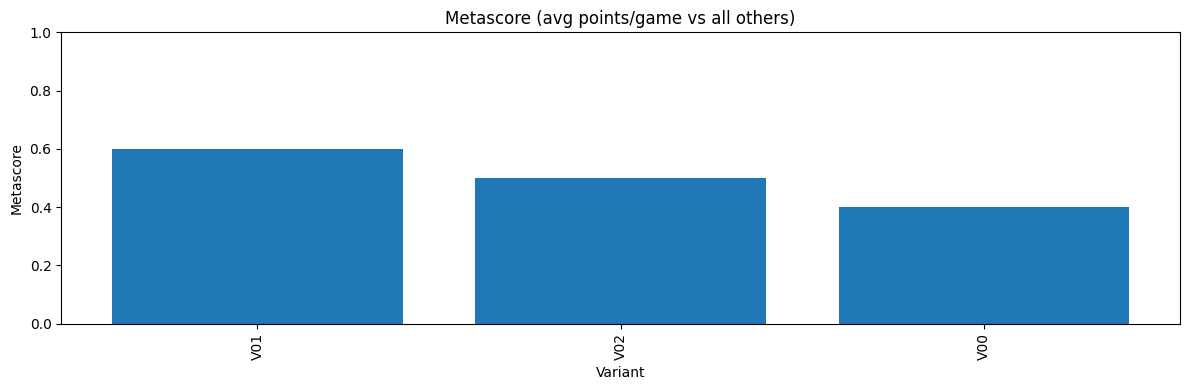

In [8]:
# --- metascore bar chart ---

fig = plt.figure(figsize=(12, 4))
ax = plt.gca()

order = df_meta.sort_values("metascore", ascending=False)
ax.bar(order["variant"].values, order["metascore"].values)

ax.set_title("Metascore (avg points/game vs all others)")
ax.set_xlabel("Variant")
ax.set_ylabel("Metascore")
ax.set_ylim(0.0, 1.0)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [9]:
# --- optional exports (Excel, readable heatmap) ---

import os
import numpy as np
import pandas as pd

EXPORT = True
OUT_DIR = "round_robin_out"

if EXPORT:
    os.makedirs(OUT_DIR, exist_ok=True)
    out_xlsx = os.path.join(OUT_DIR, "round_robin_results.xlsx")

    # Build DataFrames
    idx = [f"V{i:02d}" for i in range(N)]
    df_P = pd.DataFrame(P, index=idx, columns=idx)

    # Make diagonal "neutral" for the heatmap, but we will hide it visually in Excel.
    df_P_export = df_P.copy()
    if df_P_export.shape[0] == df_P_export.shape[1]:
        np.fill_diagonal(df_P_export.values, 0.5)

    with pd.ExcelWriter(out_xlsx, engine="openpyxl") as writer:
        df_P_export.to_excel(writer, sheet_name="ppg_matrix", index=True)
        df_meta.to_excel(writer, sheet_name="metascores", index=False)
        df_pairs.to_excel(writer, sheet_name="pair_results", index=False)

        wb = writer.book
        ws = wb["ppg_matrix"]
        ws.freeze_panes = "B2"

        # Styling helpers
        from openpyxl.utils import get_column_letter
        from openpyxl.styles import PatternFill, Alignment, Font, Border, Side
        from openpyxl.formatting.rule import ColorScaleRule

        # Column widths
        ws.column_dimensions["A"].width = 10
        for c in range(2, N + 2):
            ws.column_dimensions[get_column_letter(c)].width = 7

        # Apply alignment, number format, borders to the matrix cells
        thin = Side(style="thin")
        border = Border(left=thin, right=thin, top=thin, bottom=thin)
        align = Alignment(horizontal="center", vertical="center")
        numfmt = "0.000"

        start_row, start_col = 2, 2
        end_row, end_col = N + 1, N + 1

        for r in range(start_row, end_row + 1):
            for c in range(start_col, end_col + 1):
                cell = ws.cell(r, c)
                cell.alignment = align
                cell.border = border
                cell.number_format = numfmt

        # Make diagonal readable: gray fill + hide text (custom format)
        diag_fill = PatternFill("solid", fgColor="D9D9D9")
        diag_font = Font(color="666666")
        for k in range(N):
            cell = ws.cell(start_row + k, start_col + k)
            cell.fill = diag_fill
            cell.font = diag_font
            cell.number_format = ';;;'

        # Add a proper heatmap color scale (explicit colors)
        # (Excel classic red -> yellow -> green)
        start_cell = ws.cell(start_row, start_col).coordinate
        end_cell = ws.cell(end_row, end_col).coordinate
        cell_range = f"{start_cell}:{end_cell}"

        rule = ColorScaleRule(
            start_type="num", start_value=0.0, start_color="F8696B",
            mid_type="num",   mid_value=0.5, mid_color="FFEB84",
            end_type="num",   end_value=1.0, end_color="63BE7B",
        )
        ws.conditional_formatting.add(cell_range, rule)

        # Freeze + light styling on other sheets too
        wb["metascores"].freeze_panes = "A2"
        wb["pair_results"].freeze_panes = "A2"

    print("Exported Excel workbook to:", out_xlsx)
else:
    print("EXPORT=False (set True to write XLSX)")


Exported Excel workbook to: round_robin_out\round_robin_results.xlsx


In [10]:
%%time
# ---------------- Evaluation vs fixed Lookahead opponents (L1..L7) ----------------
# Round-robin is "relative". This adds an "absolute" yardstick vs baseline lookahead depths.

import re
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

class FixedDepthAgent:
    # Lightweight wrapper: keeps the same public API but forces a fixed search depth.
    def __init__(self, base_agent, fixed_depth: int):
        self.base = base_agent
        self.fixed_depth = int(fixed_depth)
        # expose weights for debugging / display
        self.weights = getattr(base_agent, "weights", None)

    def legal_actions(self, board=None, mask=None):
        return self.base.legal_actions(board=board, mask=mask)

    def n_step_action_scores(self, board, player, depth=1):
        return self.base.n_step_action_scores(board, player, depth=int(depth))

    def n_step_lookahead(self, board, player, depth=3):
        # ignore passed depth, always use fixed
        return self.base.n_step_lookahead(board, player, depth=self.fixed_depth)

    def has_four(self, board, player: int) -> bool:
        return self.base.has_four(board, player)

def opponent_weight(label: str,
                    base: float = 1.4,
                    random_weight: float = 1.0,
                    default_weight: float = 1.0) -> float:
    s = str(label)
    if "Random" in s or s.strip().upper() in ("R", "RND"):
        return float(random_weight)
    m = re.search(r"(\d+)", s)
    if m:
        depth = int(m.group(1))
        return float(base) ** depth
    return float(default_weight)

def global_score_from_scores(score_map: dict, base: float = 1.4) -> float:
    # Weighted average of match *scores* in [0,1], where win=1, draw=0.5, loss=0.
    num = 0.0
    den = 0.0
    for label, s in score_map.items():
        w = opponent_weight(label, base=base)
        num += w * float(s)
        den += w
    return num / den if den > 1e-12 else float("nan")

def match_score(a1, a2, games: int, seed: int):
    # Returns (score, wins, draws, losses) from a1 POV; alternating starters.
    wins = draws = losses = 0
    for g in range(int(games)):
        rng = np.random.default_rng(int(seed) + g * 10007)
        start_player = 1 if (g % 2 == 0) else 2
        w = play_game(a1, a2, start_player=start_player, rng=rng)
        if w == 1:
            wins += 1
        elif w == 2:
            losses += 1
        else:
            draws += 1
    score = (wins + 0.5 * draws) / float(games)
    return float(score), int(wins), int(draws), int(losses)

# Controls
OPP_DEPTHS = list(range(1, 8))               # L1..L7
GAMES_VS_DEPTH = max(20, int(GAMES_PER_PAIR))
GLOBAL_BASE = 1.4
SEED_BASE = int(START_SEED) + 123456

rows_vs = []
for i, (name, agent) in enumerate(tqdm(list(zip(names, agents)), desc="Vs L1..L7", leave=False)):
    A = FixedDepthAgent(agent, DEPTH)        # candidate uses sweep depth
    score_map = {}

    for d in OPP_DEPTHS:
        opp_base = Connect4Lookahead()       # baseline opponent (default heuristic knobs)
        B = FixedDepthAgent(opp_base, d)

        s, w, dr, l = match_score(A, B, games=GAMES_VS_DEPTH, seed=SEED_BASE + i * 100000 + d * 1000)
        score_map[f"Lookahead-{d}"] = s

    rows_vs.append({
        "name": name,
        "global_score_L1L7": global_score_from_scores(score_map, base=GLOBAL_BASE),
        **score_map,
    })

df_vs = pd.DataFrame(rows_vs).sort_values("global_score_L1L7", ascending=False).reset_index(drop=True)

# Merge onto your existing RR table if present
try:
    df_out_L = df_out.merge(df_vs, on="name", how="left")
    df_out_L = df_out_L.sort_values("global_score_L1L7", ascending=False).reset_index(drop=True)
    display(df_out_L.head(20))
except NameError:
    display(df_vs.head(20))

df_vs.head(10)


NameError: name 'START_SEED' is not defined